## SSD with pre-trained MobileNet classifier

- SSD architecture and model weights from tensorflow/object-detection library
- Classifier was pre-trained on COCO 2012 dataset
- Classifier was then re-trained on data set of family vacation photos

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import cv2
from scipy.ndimage.measurements import label
from matplotlib import pyplot as plt
from moviepy.editor import VideoFileClip

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

%matplotlib inline

/home/anand/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Render bounding box
- Render bounding box to visualize recognition

In [57]:
def drawBoundingBoxes(image, boxes, classes, color=[255,255,0], thickness = 5):
    t = thickness // 2
    for idx, (y0,x0,y1,x1) in enumerate(boxes):
        image[ y0-t:y0+t, x0:x1 ] = color
        image[ y1-t:y1+t, x0:x1 ] = color
        image[ y0:y1, x0-t:x0+t ] = color
        image[ y0:y1, x1-t:x1+t ] = color
        cv2.putText(image, "Class: {0}".format(classes[idx]), (x0,y0), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.7, color=color)

### Load Model
- Load pre-trained Inception V3 classifier

In [58]:
MODEL='/home/anand/code/data/models/family/inference_graph/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Process test images

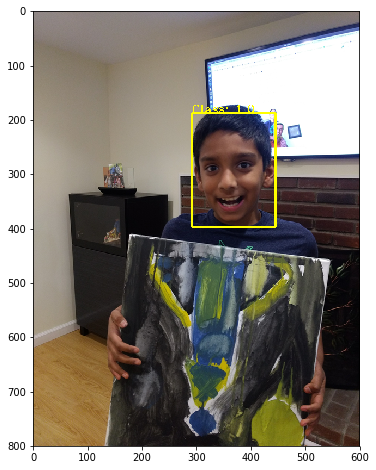

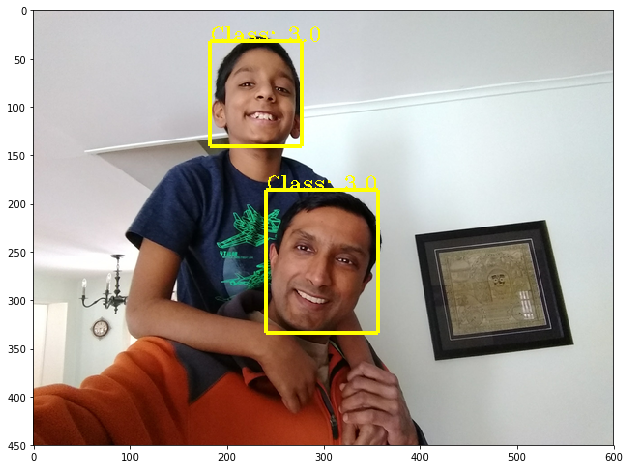

In [59]:
with tf.Session(graph = detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in glob.glob('/home/anand/code/data/family/test_images/*.png'):

        #for scale in [1.75]:
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

            #image_np = cv2.resize(image_np, dsize=(0,0), fx=scale, fy=scale)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            boxes = np.squeeze(boxes)
            classes = np.squeeze(classes)
            scores = np.squeeze(scores)

            boxes = boxes[scores > 0.5]

            h,w,_ = image_np.shape

            # Scale boxes to image size
            boxes = (boxes * np.array([h,w,h,w])).astype(np.int32)

            # Visualization of the results of a detection.
            drawBoundingBoxes(image_np, boxes, classes[scores > 0.5])

            #print("{0} detections\n classes:{1}\n scores:{2}\n boxes:{3}".format(num, classes, scores, boxes))            

            plt.figure(figsize=(12, 8))
            plt.imshow(image_np)